## Hamoye Premier Project (Kmeans)

### Project Objective:
   
   Predicting whether a news is fake based on text with an accuracy of 95%. 

### Preprocessing:

   We used texthero library to implement cleaning (very fast and efficient text preprocessing tool)

### Visualization

1) Top words

2) Word cloud

3) Length of tokenized sequence

### Modelling Technique:

   `Neural network`

### Project result

   Model 2 give us an accuracy of 99.5% after few modifications


In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

# Preprocessing
import texthero as hero
from texthero import preprocessing as ppe
from texthero import visualization as viz
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# Modelling
# import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

# Accuracy library
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Fake News_Prediction/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Fake News_Prediction/test.csv')

In [4]:
# Features to be used
train1 = train[['text', 'label']]
test1 = test[['text']]

## Preprocessing

In [5]:
# We create a custom pipeline with the list of functions that we want to apply in our dataset.
custom_pipeline = [
                   ppe.remove_whitespace,
                   ppe.remove_punctuation,
                   ppe.remove_digits,
                   ppe.fillna,
                   ppe.remove_whitespace,
                   ppe.remove_brackets,
                   ppe.lowercase,
                   ppe.remove_stopwords]
                  

train1['clean_text'] = hero.clean(train1['text'], custom_pipeline)
test1['clean_text'] = hero.clean(test1['text'], custom_pipeline)

/usr/local/lib/python3.8/dist-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/usr/local/lib/python3.8/dist-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/usr/local/lib/python3.8/dist-packages/texthero/preprocessing.py:447: FutureWarning: The default value of regex will change from True to False in a future version.
  return s.str.replace(r"\([^()]*\)", "")
/usr/local/lib/python3.8/dist-packages/texthero/preprocessing.py:469: FutureWarning: The default value of regex will change from True to False in a future version.
  return s.str.replace(r"\{[^{}]*\}", "")
/usr/local/lib/python3.8/dist-packages/texthero/preprocessing.py:493: FutureWarning: The default value of regex will change from True to False in a fu

/usr/local/lib/python3.8/dist-packages/texthero/visualization.py:181: FutureWarning: The default value of regex will change from True to False in a future version.
  s.str.replace(


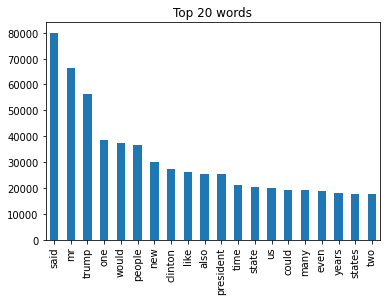

In [6]:
# Let's see the top 20 words after removing stopwords
TOP_WORDS = 20

top_20 = hero.visualization.top_words(train1['clean_text']).head(TOP_WORDS)

# Draw the bar chart

top_20.plot.bar(rot=90, title="Top 20 words");

plt.show(block=True);

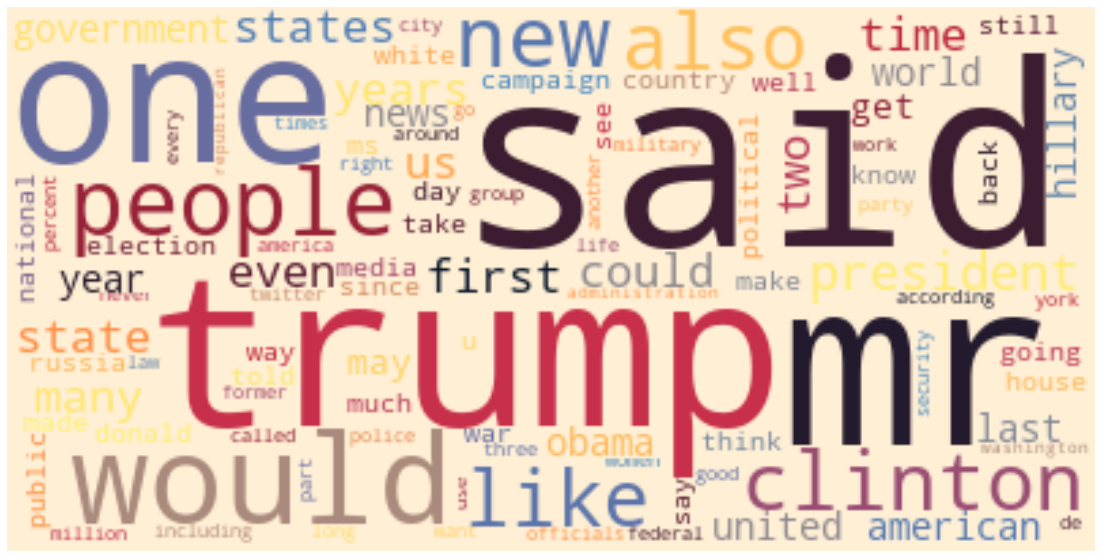

In [7]:
# Word Clouds are a powerful way to visualise what your audience really thinks about a topic
# We see words such as trump, clinton, president, russia etc
# Top 100 words
hero.wordcloud(train1.clean_text, max_words=100,)

In [8]:
# We split the data
trainx, testx, trainy, testy = train_test_split(train1['text'], train1['label'], test_size=0.2)
print('The number of train set: ', trainx.shape[0])
print('The number of test set: ', testx.shape[0])

The number of train set:  16640
The number of test set:  4160


In [9]:
MAX_NUM_WORDS = 10000

# We get the original text data
train_X = trainx.astype(str)
test_X = testx.astype(str)

# We vectorize the these text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, char_level=False)
tokenizer.fit_on_texts(train_X)
sequences = tokenizer.texts_to_sequences(train_X)
sequences_test = tokenizer.texts_to_sequences(test_X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 211676 unique tokens.


#### The word strings that make up the vocabulary stored in the tokenizer object can be inverted to recreate the original message (excluding modifying)

In [10]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 211676)

In [11]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in sequences[0]])

'like a little crew of the first few faces out of the on a recent evening in central park their button eyes with each flash of a smartphone camera several of the animals onto the toward the picture they were followed by more — and then still more all told 22 on a path near the edge of the park where it meets street in manhattan they around while a of tried to pose for with them some people fed the animals soft from a by hand as the stood on their legs to from their “is this normal ” karen 56 a from n c asked her sister price who lives in manhattan as they passed the one of the animals toward a baby in a “no it’s not normal ” ms price 48 said “they’re so though ” in fact the of at the edge of the in central park has become something of a tourist attraction with unofficial visiting hours each evening with their winter and perhaps all those in or in dozens the animals on the as soon as it gets dark they look for with the practice of feeding them however is upon by new york city’s parks de

In [12]:
# Let's examine the tokenized sequences in more detail.
seq_lens = [len(s) for s in sequences]
mean_seq = np.mean(seq_lens) 
max_seq = max(seq_lens)

print(f'average length: %0.1f' % mean_seq)
print("max length: %d" % max_seq)

average length: 697.5
max length: 22690


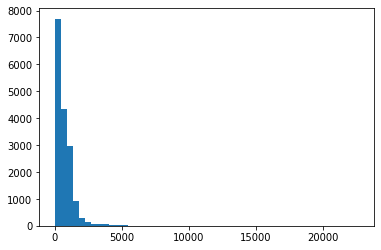

In [13]:
plt.hist(seq_lens, bins=50);

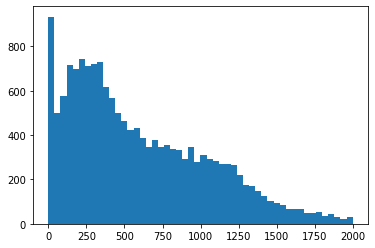

In [14]:
plt.hist([l for l in seq_lens if l < 2000], bins=50);

In [15]:
MAX_SEQUENCE_LENGTH = 500

# We pad sequences with 0s
X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)

Shape of data tensor: (16640, 500)
Shape of data test tensor: (4160, 500)


In [16]:
y_train = trainy
y_test = testy

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (16640, 2)


In [17]:
# Modeling
EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model_1 = Model(sequence_input, predictions)
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [18]:
his = model_1.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=128)

Epoch 1/10
117/117 [==============================] - 3s 5ms/step - loss: 0.6209 - accuracy: 0.6542 - val_loss: 0.5469 - val_accuracy: 0.6911
Epoch 2/10
117/117 [==============================] - 1s 4ms/step - loss: 0.5003 - accuracy: 0.7590 - val_loss: 0.4214 - val_accuracy: 0.8365
Epoch 3/10
117/117 [==============================] - 0s 4ms/step - loss: 0.3822 - accuracy: 0.8562 - val_loss: 0.3236 - val_accuracy: 0.8888
Epoch 4/10
117/117 [==============================] - 0s 4ms/step - loss: 0.3010 - accuracy: 0.8913 - val_loss: 0.2666 - val_accuracy: 0.9177
Epoch 5/10
117/117 [==============================] - 0s 3ms/step - loss: 0.2483 - accuracy: 0.9166 - val_loss: 0.2295 - val_accuracy: 0.9273
Epoch 6/10
117/117 [==============================] - 0s 4ms/step - loss: 0.2109 - accuracy: 0.9324 - val_loss: 0.2031 - val_accuracy: 0.9345
Epoch 7/10
117/117 [==============================] - 0s 4ms/step - loss: 0.1830 - accuracy: 0.9443 - val_loss: 0.1840 - val_accuracy: 0.9411
Epoch 

In [19]:
output_test1 = model_1.predict(X_test)
print("test auc:", roc_auc_score(y_test,output_test1[:,1]))

130/130 [==============================] - 0s 1ms/step
test auc: 0.9897471977678356


In [20]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 50)           500000    
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 500,102
Trainable params: 500,102
Non-trainable params: 0
_________________________________________________________________


In [21]:
pd.DataFrame(his.history)

,loss,accuracy,val_loss,val_accuracy
0,0.620872,0.654247,0.546867,0.691106
1,0.500278,0.759014,0.421447,0.836538
2,0.382171,0.856170,0.323597,0.888822
3,0.301013,0.891293,0.266605,0.917668
4,0.248315,0.916600,0.229490,0.927284
5,0.210856,0.932425,0.203053,0.934495
6,0.183022,0.944311,0.183958,0.941106
7,0.161629,0.951856,0.169251,0.946514
8,0.143719,0.957866,0.157728,0.948317
9,0.129206,0.963542,0.147256,0.952524


Text(0.5, 1.0, 'Model_1 training curves')

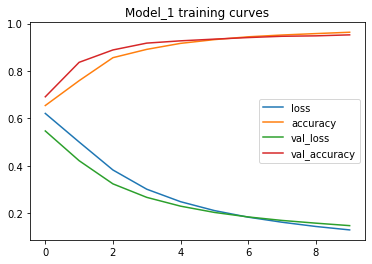

In [22]:
# Plot the loss curves
pd.DataFrame(his.history).plot()
plt.title("Model_1 training curves")

## Let's do another model, we remove the validation, increase our epoch to 20 and increase our embedding dimension to 100.

In [23]:
# Modeling
EMBEDDING_DIM = 100
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model_2 = Model(sequence_input, predictions)
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [24]:
hist = model_2.fit(X_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
130/130 [==============================] - 1s 4ms/step - loss: 0.5928 - acc: 0.6662
Epoch 2/20
130/130 [==============================] - 1s 4ms/step - loss: 0.4123 - acc: 0.8348
Epoch 3/20
130/130 [==============================] - 1s 4ms/step - loss: 0.2858 - acc: 0.8980
Epoch 4/20
130/130 [==============================] - 1s 4ms/step - loss: 0.2188 - acc: 0.9276
Epoch 5/20
130/130 [==============================] - 1s 4ms/step - loss: 0.1768 - acc: 0.9451
Epoch 6/20
130/130 [==============================] - 0s 4ms/step - loss: 0.1483 - acc: 0.9552
Epoch 7/20
130/130 [==============================] - 1s 4ms/step - loss: 0.1261 - acc: 0.9641
Epoch 8/20
130/130 [==============================] - 0s 4ms/step - loss: 0.1091 - acc: 0.9697
Epoch 9/20
130/130 [==============================] - 0s 4ms/step - loss: 0.0948 - acc: 0.9737
Epoch 10/20
130/130 [==============================] - 0s 4ms/step - loss: 0.0831 - acc: 0.9779
Epoch 11/20
130/130 [============================

In [25]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,000,202
Trainable params: 1,000,202
Non-trainable params: 0
_________________________________________________________________


In [26]:
pd.DataFrame(hist.history)

,loss,acc
0,0.592835,0.666226
1,0.412309,0.834796
2,0.285792,0.897957
3,0.218783,0.927644
4,0.176842,0.945132
5,0.148262,0.955168
6,0.126124,0.964063
7,0.109088,0.969651
8,0.094767,0.973738
9,0.083150,0.977885


Text(0.5, 1.0, 'Model_2 training curves')

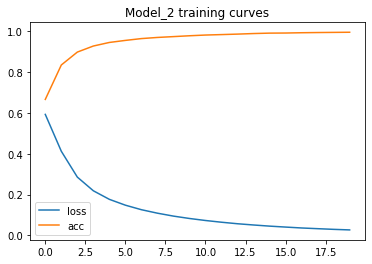

In [27]:
# Plot the loss curves
pd.DataFrame(hist.history).plot()
plt.title("Model_2 training curves")

In [28]:
output_test = model_2.predict(X_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

130/130 [==============================] - 0s 1ms/step
test auc: 0.9932321791356283


In [29]:
emb_layer_output = K.function([model_2.layers[0].input],
                              [model_2.layers[2].input])
embedding_output = emb_layer_output([X_test[:5000]])[0]

In [30]:
emb_shape = embedding_output.shape
embedding_plot = embedding_output.reshape(emb_shape[0],emb_shape[1]*emb_shape[2])
y = y_test[:5000]

In [31]:
# We use tsne to visualize our embeddings
emb_sentence_tsne = TSNE(perplexity=50).fit_transform(embedding_plot)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [32]:
print(emb_sentence_tsne.shape)
print(y.shape)

(4160, 2)
(4160,)


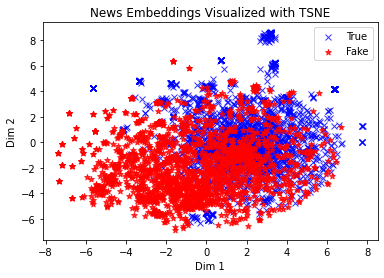

In [33]:
plt.figure()
plt.scatter(emb_sentence_tsne[np.where(y == 0), 0],
                   emb_sentence_tsne[np.where(y == 0), 1],
                   marker='x', color='b',
                   linewidth='1', alpha=0.8, label='True')
plt.scatter(emb_sentence_tsne[np.where(y == 1), 0],
                   emb_sentence_tsne[np.where(y == 1), 1],
                   marker='*', color='r',
                   linewidth='1', alpha=0.8, label='Fake')

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('News Embeddings Visualized with TSNE')
plt.legend(loc='best')
# plt.savefig('1.png')
plt.show();

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


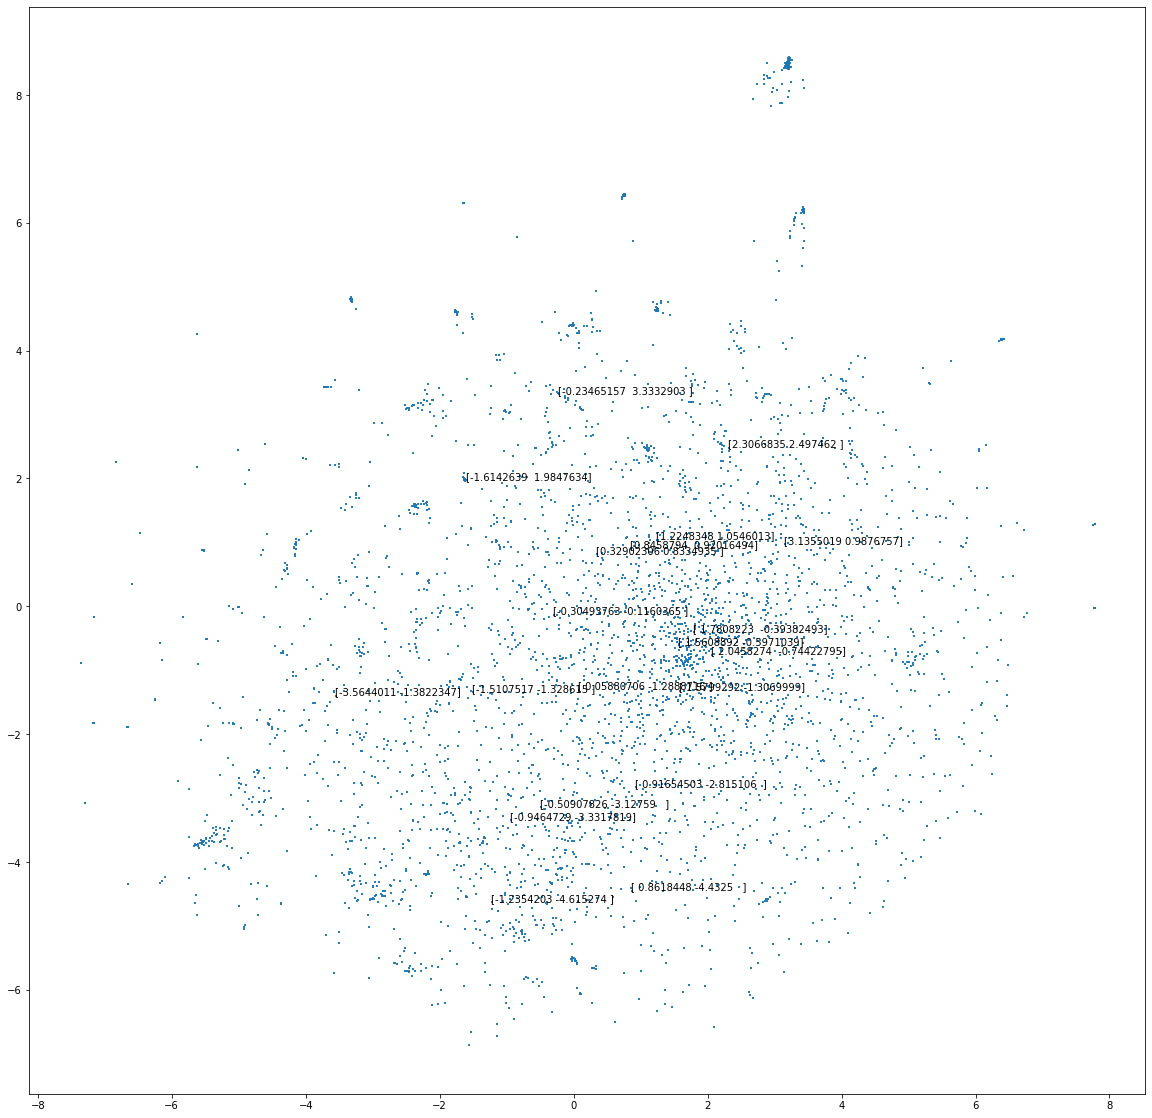

In [34]:
# This is similar to the above....we can drop this.
plt.figure(figsize=(20, 20))
axis = plt.gca()
np.set_printoptions(suppress=True)
plt.scatter(emb_sentence_tsne[:, 0], emb_sentence_tsne[:, 1], marker="s", s=1)

for idx in range(20):
    plt.annotate(emb_sentence_tsne[idx],
                 xy=(emb_sentence_tsne[idx, 0], emb_sentence_tsne[idx, 1]),
                 xytext=(0, 0), textcoords='offset points')
plt.savefig("tsne.png")
plt.show()


In [35]:
# Save model to file
from tensorflow.keras.models import load_model
model_2.save("/content/drive/MyDrive/Fake News_Prediction/saved_model/model.hdf5")

## You can read more on this here
`github link`
https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/NLP_word_vectors_classification_rendered.ipynb

`Research paper on TSNE`
https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

`kaggle`
https://www.kaggle.com/code/eliotbarr/text-classification-using-neural-networks
